# Create new utility function

Import data.

In [5]:
%load_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.from_sdf(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
load data


In [2]:
building_blocks = dg.datasets.enamine(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630.fpb')

# align fingerprints to building blocks
print('align fingerprints')
fingerprints = dg.utils.sort_fingerprints(fingerprints, building_blocks)

# partition building blocks according to functional groups
print('partition building blocks')
templates = dg.utils.get_unique_reactants(reactions)
building_blocks = dg.utils.partition_building_blocks(building_blocks, templates, out_dir=path)

align fingerprints
partition building blocks


In [103]:
from dgym.envs.library_designer import LibraryDesigner
from dgym.envs.oracle import DGLOracle, RDKitOracle

library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

clogp_oracle = RDKitOracle('MolLogP')
lipo_oracle = DGLOracle('GCN_canonical_Lipophilicity')
esol_oracle = DGLOracle('GCN_canonical_ESOL')

Get some data on the deck.

In [105]:
import numpy as np

def utility_function(logP, logS, 
                   target_logP=2.5, target_logS=-2, 
                   logP_range=(2, 3), logS_range=(-3, 0), 
                   k=5):
    
    # Scoring function for properties
    def score_property(value, target, acceptable_range):
        lower, upper = acceptable_range
        if lower <= value <= upper:
            return 1
        else:
            return np.exp(-k * min(abs(value - lower), abs(value - upper)))
    
    score_logP = score_property(logP, target_logP, logP_range)
    score_logS = score_property(logS, target_logS, logS_range)

    # Combine the scores, assuming equal importance
    utility = (score_logP + score_logS) / 2

    return np.clip(utility, -1, 1)

utility_function(8, -6)

1.529581042228454e-07

In [138]:
import numpy as np

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x)

def utility_function(logS, logP):
    values = [1, 0, -1]  # Good, neutral, bad
    logits = [logS, logP, 0]  # Assign logS and logP to corresponding logits

    probabilities = softmax(logits)

    utility = np.dot(values, probabilities)

    return utility

# Example usage
logS = -2.0
logP = 3.0

result = utility_function(logS, logP)
print(result)

-0.040745955602221856


In [174]:
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def drug_score(logS, logP, ideal_bounds, acceptable_bounds):
    """
    Calculate a score for a molecule based on its logS and logP values.
    
    Parameters:
    - logS: log S value of the molecule
    - logP: log P value of the molecule
    - ideal_bounds: a dictionary with keys 'logS' and 'logP' containing tuples of (min, max) ideal bounds
    - acceptable_bounds: a dictionary with keys 'logS' and 'logP' containing tuples of (min, max) acceptable bounds
    
    Returns:
    - A score indicating the suitability of the molecule as an oral drug.
    """
    
    # Define a function to calculate the score for a single property (either logS or logP)
    def property_score(value, ideal, acceptable):
        if ideal[0] <= value <= ideal[1]:
            return 1
        elif acceptable[0] <= value <= acceptable[1]:
            # Use sigmoid for smooth transition in the acceptable range
            if value < ideal[0]:
                return sigmoid(10 * (value - acceptable[0]) / (ideal[0] - acceptable[0]))
            else:
                return sigmoid(10 * (acceptable[1] - value) / (acceptable[1] - ideal[1]))
        else:
            # Exponential penalty outside the acceptable range
            if value < acceptable[0]:
                return -math.exp(-value + acceptable[0])
            else:
                return -math.exp(value - acceptable[1])
    
    # Calculate scores for logS and logP
    s_score = property_score(logS, ideal_bounds['logS'], acceptable_bounds['logS'])
    p_score = property_score(logP, ideal_bounds['logP'], acceptable_bounds['logP'])
    
    # Combine the scores
    return s_score * p_score

# Define ideal and acceptable bounds
ideal_bounds = {
    'logS': (-2, 0.0),  # Example bounds for logS
    'logP': (0, 5)    # Example bounds for logP
}

acceptable_bounds = {
    'logS': (-4, 0.5),  # Example bounds for logS
    'logP': (-0.5, 5.5)   # Example bounds for logP
}

# Test the function
logS_value = -4
logP_value = 5.5
print(drug_score(logS_value, logP_value, ideal_bounds, acceptable_bounds))

0.25


/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


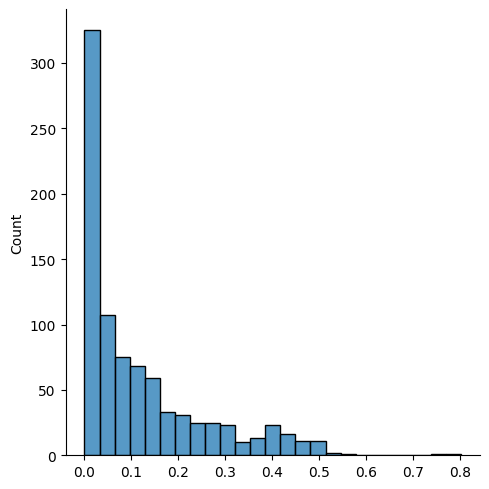

In [139]:
import seaborn as sns

sns.displot(utility)

In [151]:
np.sort(utility)[-1]

0.8027039084604666

In [153]:
# deck[utility.argsort()[-1:]][0]

In [154]:
assays = [lipo_oracle, esol_oracle]
for assay_index, assay in enumerate(assays):
    
    # update library annotations for molecules measured
    results = assay.predict(deck)    
    for molecule_index, molecule in enumerate(deck):
        molecule.update_annotations({f'{assay.model_name}': results[molecule_index]})
        
utility = utility_function(
    deck.annotations['GCN_canonical_Lipophilicity'].values,
    deck.annotations['GCN_canonical_ESOL'].values
)

# housekeeping
best_observed = 0.0 # utility.max()

best_over_time = [best_observed]
dist_over_time = [sorted(utility)[-110:-100]]

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

First, set up the environment.

In [72]:
from dgym.envs import DrugEnv

drug_env = DrugEnv(
    library_designer,
    library = deck,
    assays = assays,
    budget = 100_000
)

# # score all molecules
# drug_env.step(
#     {'order': {'assay': 0, 'molecules': range(len(drug_env.library))}}
# )
# drug_env.step(
#     {'order': {'assay': 1, 'molecules': range(len(drug_env.library))}}
# )
print(drug_env.library)

MoleculeCollection with 860 Molecules


In [73]:
import random
import numpy as np

chosen_molecules = utility.argsort()[-110:-100]

num_rounds = 15
for _ in range(num_rounds):

    # ideate
    action = {
        'design': {
            'molecules': chosen_molecules,
            'num_analogs': 2, # maps to 10 molecules
            'fraction_random': 0.0
        }
    }
    library = drug_env.step(action)[0]

    # score
    assay_results = []
    for assay in assays:
        assay_results.append(np.array(assay.predict(library)))
    utility = utility_function(*assay_results)
    
    # triage
    chosen_molecules = utility.argsort()[-8:].tolist()
    chosen_molecules.extend(random.sample(range(len(library)), 2))

    # housekeeping
    best_observed = max([*utility, best_observed])
    best_over_time.append(best_observed)
    dist_over_time.append(utility[chosen_molecules])

    # assay
    drug_env.step({'order': {'assay': 0, 'molecules': chosen_molecules}})
    drug_env.step({'order': {'assay': 1, 'molecules': chosen_molecules}})
    print(_, '\t', drug_env.library, '\t', best_observed)
    
    # update model (TODO)

0 	 MoleculeCollection with 3982 Molecules 	 0.9863218545972967
1 	 MoleculeCollection with 7554 Molecules 	 0.9943175533298707
2 	 MoleculeCollection with 12133 Molecules 	 0.9953217037737141
3 	 MoleculeCollection with 16656 Molecules 	 0.9953217037737141
4 	 MoleculeCollection with 21157 Molecules 	 0.9953217037737141
5 	 MoleculeCollection with 25637 Molecules 	 0.9953217037737141
6 	 MoleculeCollection with 30420 Molecules 	 0.9953217037737141
7 	 MoleculeCollection with 34963 Molecules 	 0.9953217037737141
8 	 MoleculeCollection with 40080 Molecules 	 0.9953217037737141
9 	 MoleculeCollection with 45096 Molecules 	 0.9953217037737141
10 	 MoleculeCollection with 49777 Molecules 	 0.9953217037737141
11 	 MoleculeCollection with 54279 Molecules 	 0.9953217037737141
12 	 MoleculeCollection with 59071 Molecules 	 0.9953217037737141
13 	 MoleculeCollection with 63795 Molecules 	 0.9953217037737141
14 	 MoleculeCollection with 68336 Molecules 	 0.9953217037737141


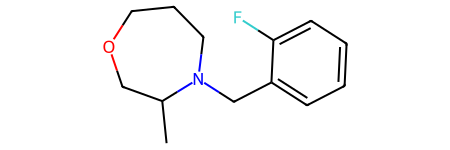

In [68]:
drug_env.library[-5]

In [69]:
from collections import Counter

original_inspirations = []
for mol in drug_env.library:
    while mol.inspiration:
        mol = mol.inspiration
    original_inspirations.append(mol)
    
Counter([o.mol for o in original_inspirations]).most_common(20)

[(<rdkit.Chem.rdchem.Mol at 0x7fe409f69bd0>, 2495),
 (<rdkit.Chem.rdchem.Mol at 0x7fe40a196a40>, 187),
 (<rdkit.Chem.rdchem.Mol at 0x7fe40a1d1540>, 156),
 (<rdkit.Chem.rdchem.Mol at 0x7fe40a140200>, 145),
 (<rdkit.Chem.rdchem.Mol at 0x7fe40a1fa490>, 96),
 (<rdkit.Chem.rdchem.Mol at 0x7fe428ffbe60>, 83),
 (<rdkit.Chem.rdchem.Mol at 0x7fe40a1614d0>, 81),
 (<rdkit.Chem.rdchem.Mol at 0x7fe40a160cf0>, 77),
 (<rdkit.Chem.rdchem.Mol at 0x7fe40a10bed0>, 62),
 (<rdkit.Chem.rdchem.Mol at 0x7fe40a1433e0>, 50),
 (<rdkit.Chem.rdchem.Mol at 0x7fe40a1d26c0>, 50),
 (<rdkit.Chem.rdchem.Mol at 0x7fe40a1f9070>, 49),
 (<rdkit.Chem.rdchem.Mol at 0x7fe409f690e0>, 47),
 (<rdkit.Chem.rdchem.Mol at 0x7fe40a162180>, 45),
 (<rdkit.Chem.rdchem.Mol at 0x7fe40a195f50>, 45),
 (<rdkit.Chem.rdchem.Mol at 0x7fe40a1b6a40>, 45),
 (<rdkit.Chem.rdchem.Mol at 0x7fe40a1f8430>, 45),
 (<rdkit.Chem.rdchem.Mol at 0x7fe40a1d0040>, 43),
 (<rdkit.Chem.rdchem.Mol at 0x7fe40a1082e0>, 39),
 (<rdkit.Chem.rdchem.Mol at 0x7fe42ad5c6d0>, 

In [30]:
# import pandas as pd
# pd.DataFrame(
#     Counter([o.mol for o in original_inspirations]).most_common(20)
# )[0][0]

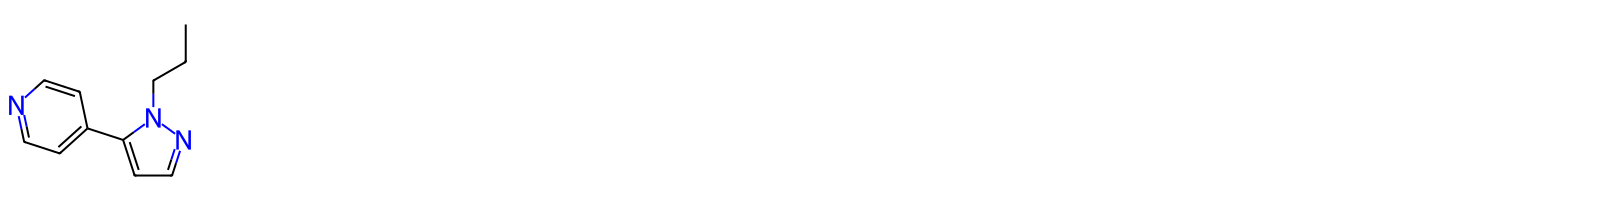

In [130]:
from rdkit.Chem import Draw

mol = drug_env.library[4]

lineage = [mol]
results = []
while mol.inspiration:
    mol = mol.inspiration
    lineage.append(mol)
    try:
        results.append(
            utility_function(
                mol.annotations['GCN_canonical_Lipophilicity'],
                mol.annotations['GCN_canonical_ESOL']
            )
        )
    except:
        pass

display(*results[::-1])
display(Draw.MolsToGridImage(
    [m.mol for m in lineage][::-1],
    molsPerRow=8,
    maxMols=10_000
))

In [19]:
from dgym.collection import MoleculeCollection

# ideate
results = MoleculeCollection(
    drug_env.design_library(action['design'])
)

# score
assay_results = []
for assay in assays:
    assay_results.append(np.array(assay.predict(results)))
utility = composite_score(*assay_results)

  0%|          | 0/5 [00:00<?, ?it/s]

<Axes: >

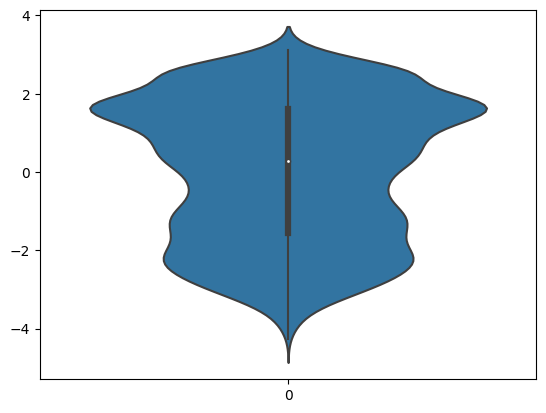

In [10]:
import seaborn as sns

sns.violinplot(utility)

In [23]:
# score
assay_results = []
for assay in assays:
    assay_results.append(np.array(assay.predict(library)))
utility = composite_score(*assay_results)

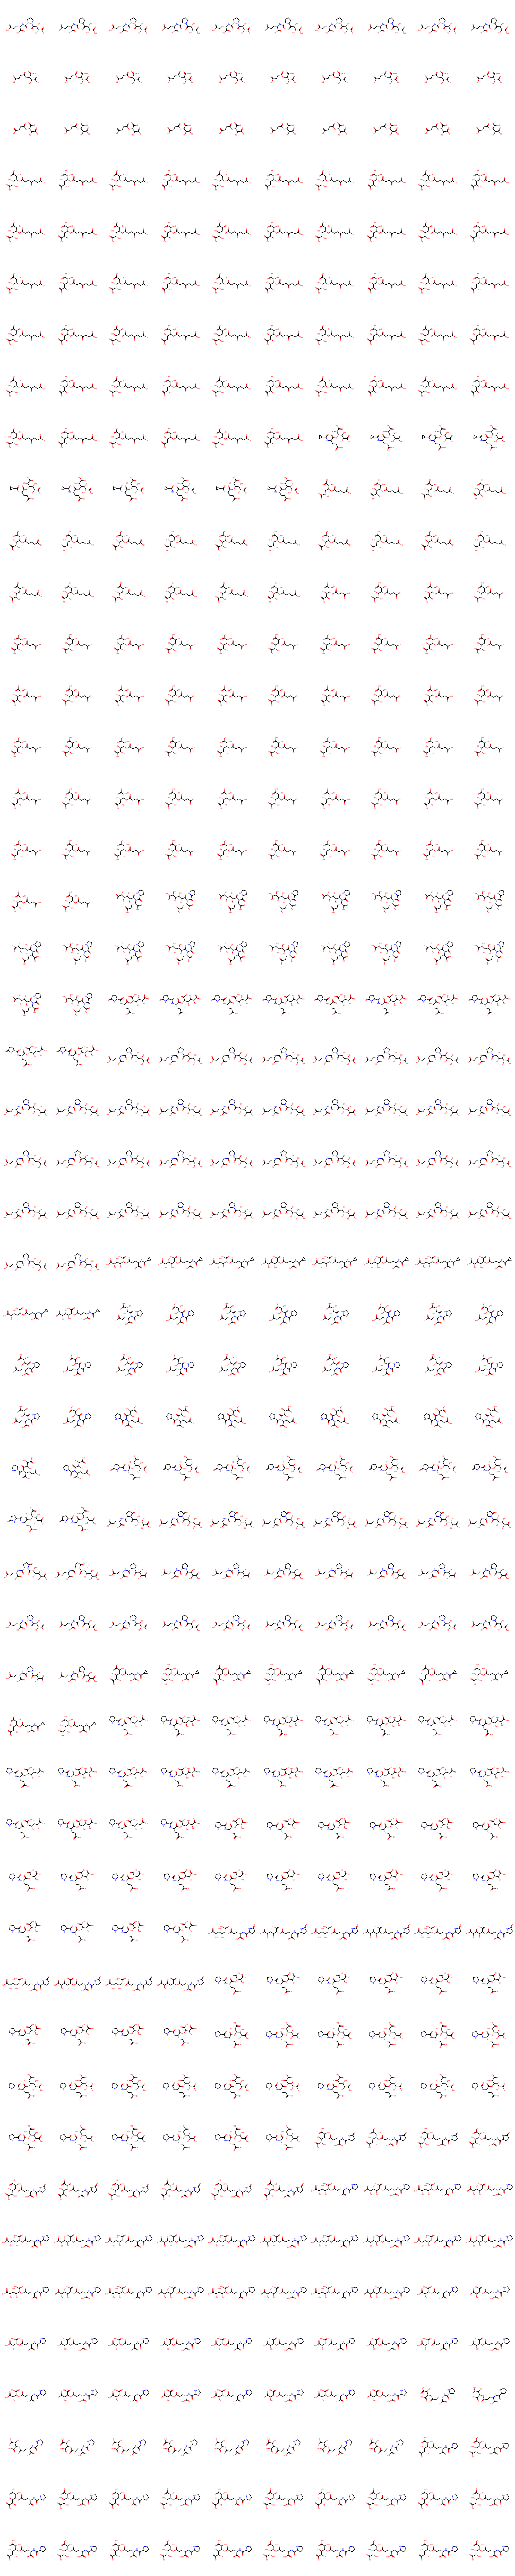

In [11]:
from rdkit.Chem import Draw

Draw.MolsToGridImage(
    [m.update_cache().mol for m in library[utility.argsort()][-500:]],
    molsPerRow=10,
    maxMols=10_000
)

<Axes: >

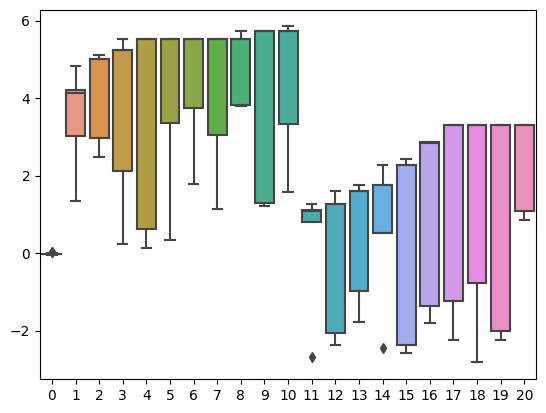

In [38]:
sns.boxplot(dist_over_time)

In [32]:
from dgym.agents import DrugAgent

In [33]:
drug_agent = DrugAgent(drug_env.action_space)